# 0.24 Distributed Training: DataParallel vs DistributedDataParallel

## Author:
* Felix Hirwa Nshuti

This notebook provides a comprehensive guide to distributed training in PyTorch, comparing two primary methods:

1.  **`nn.DataParallel`**: A simpler, more beginner-friendly approach to using multiple GPUs.
2.  **`nn.DistributedDataParallel` (DDP)**: A more advanced and significantly faster method for multi-GPU and multi-machine training.

We will use the **MNIST dataset** to train a simple model and use `time` to compare the performance of both methods. We will also cover how to correctly save and load models for each approach.

## 0. A sneak peek at Distributed Training Concepts

Before we dive into the code, let's clarify the main concepts behind distributed training. When we talk about distributed training, we are usually referring to two main strategies: **Data Parallelism** and **Model Parallelism**.

### Data Parallelism

This is the most common approach and the one we'll focus on in this notebook. The core idea is to speed up training by processing more data at once. Here's how it works:

1.  **Replicate the Model**: The same model is copied to every available GPU.
2.  **Split the Data**: A large batch of data is divided into smaller mini-batches.
3.  **Parallel Processing**: Each GPU takes one of these mini-batches and runs a forward pass with its local copy of the model to compute the loss.
4.  **Synchronize Gradients**: The gradients from each GPU are collected, averaged, and synchronized.
5.  **Update Weights**: The model weights on all GPUs are updated with the synchronized gradients, ensuring they stay identical.

This way, you can train on much larger batches, which can lead to faster convergence. `nn.DataParallel` and `nn.DistributedDataParallel` are both implementations of data parallelism.

### Model Parallelism (and Tensor Parallelism)

What if your model is so massive that it doesn't fit into a single GPU's memory? That's where **Model Parallelism** comes in.

Instead of replicating the model, you split the model itself across multiple GPUs. For example, some layers of a neural network might be on GPU 0, and the rest on GPU 1. The data flows from one GPU to the next as it passes through the layers.

A more advanced form of this is **Tensor Parallelism**, where individual tensors (like large weight matrices) are split across GPUs. This is useful for massive models like large language models (LLMs).

For this notebook, we'll stick to **Data Parallelism**, as it's the most relevant for training typical models on multiple GPUs.

## 1. Setup: Imports, Model, and Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

In [2]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = torch.device("cuda")
    print(f"Number of available GPUs: {num_gpus}")
else:
    device = device = torch.device("cpu")

Number of available GPUs: 2


In [3]:
# a simple CNN for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

## 2. `nn.DataParallel` (Beginner-Friendly)

`DataParallel` is the simplest way to use multiple GPUs. You wrap your model in `nn.DataParallel`, and it will automatically split the data and send it to your available GPUs.

`DataParallel` handles this by distributing the workload across threads, where each thread is in charge of a GPU, and one of the GPUs is selected as a primary GPU to initiate data parallelism.

**Pros:**
- Very easy to implement.
- Requires minimal code changes.

**Cons:**
- Can be slower than DDP due to the GIL and single-process-multiple-threads model.
- Can lead to GPU memory imbalance, with the primary GPU using more memory.

In [5]:
model_dp = SimpleCNN()
if num_gpus > 1:
    print(f"Using {num_gpus} GPUs for DataParallel.")
    model_dp = nn.DataParallel(model_dp)
model_dp.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dp.parameters(), lr=0.01, momentum=0.9)

print("Starting DataParallel training...")
start_time = time.time()
for epoch in range(5):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_dp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

dp_time = time.time() - start_time
print(f"DataParallel training finished in {dp_time:.2f} seconds.")

Using 2 GPUs for DataParallel.
Starting DataParallel training...
Epoch [1/5], Step [100/235], Loss: 0.3178
Epoch [1/5], Step [200/235], Loss: 0.1532
Epoch [2/5], Step [100/235], Loss: 0.1709
Epoch [2/5], Step [200/235], Loss: 0.0515
Epoch [3/5], Step [100/235], Loss: 0.1204
Epoch [3/5], Step [200/235], Loss: 0.0378
Epoch [4/5], Step [100/235], Loss: 0.0641
Epoch [4/5], Step [200/235], Loss: 0.0249
Epoch [5/5], Step [100/235], Loss: 0.0249
Epoch [5/5], Step [200/235], Loss: 0.0562
DataParallel training finished in 18.31 seconds.


### Saving and Loading `DataParallel` Models

When you save a model wrapped in `DataParallel`, the state dictionary is saved with a `module.` prefix in the keys. You need to account for this when loading the model.

In [6]:
# save the model
# access the underlying model with .module
if isinstance(model_dp, nn.DataParallel):
    torch.save(model_dp.module.state_dict(), 'mnist_cnn_dp.pth')
else:
    torch.save(model_dp.state_dict(), 'mnist_cnn_dp.pth')
print("DataParallel model saved.")

# load the model
loaded_model_dp = SimpleCNN()
loaded_model_dp.load_state_dict(torch.load('mnist_cnn_dp.pth', weights_only=True))
loaded_model_dp.to(device)
loaded_model_dp.eval()
print("DataParallel model loaded and set to evaluation mode.")

DataParallel model saved.
DataParallel model loaded and set to evaluation mode.


## 3. `nn.DistributedDataParallel` (DDP) (Advanced & Faster)

DDP is the recommended approach for distributed training. It uses multiprocessing, where each GPU gets its own process, avoiding the GIL limitations of `DataParallel`.

Each process is assigned a GPU

**Pros:**
- Significantly faster than `DataParallel`.
- Works for both multi-GPU and multi-machine training.
- Each process has its own optimizer and performs its own weight updates, which is more efficient.

**Cons:**
- More complex to set up. Requires initializing a process group.
- Requires a different way of launching the script (e.g., using the `torchrun` utility or programmatically with `torch.multiprocessing.spawn`).

> **Note on Environment Variables:**
> When you use a launcher like `torchrun`, essential environment variables like `RANK` (the global rank of the process), `LOCAL_RANK` (the local rank on the machine), and `WORLD_SIZE` (the total number of processes) are set automatically for you. If you were to manage the process spawning yourself (e.g., with `torch.multiprocessing.spawn`), you would be responsible for assigning these values manually.

In [7]:
import sys
# We use sys.executable to ensure we're using the python from our current env
!{sys.executable} -m torch.distributed.run --nproc_per_node={num_gpus} --nnodes=1 ddp_helpers.py

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Epoch 0 | Average Loss: 1.6543
Epoch 1 | Average Loss: 0.4068
Epoch 2 | Average Loss: 0.2705
Epoch 3 | Average Loss: 0.2126
Epoch 4 | Average Loss: 0.1725
Total DDP Training Time: 6.09s


### Understanding `dist.all_reduce()` for Loss Aggregation

In the `ddp_helpers.py` script, you'll notice this line:

```python
dist.all_reduce(loss, op=dist.ReduceOp.SUM)
```

You might wonder why this is necessary when DDP already handles gradient synchronization. Here's the breakdown:

-   **Automatic Gradient Reduction**: `DistributedDataParallel` automatically performs an `all_reduce` operation on the gradients during the backward pass. This ensures that every process has the same averaged gradients before the optimizer updates the model weights.

-   **Manual Loss Reduction**: However, DDP **does not** automatically synchronize other values, like the loss. Each process calculates its own loss based on its slice of the data. If you want to log the *total* or *average* loss across all GPUs, you need to manually aggregate it.

That's what `dist.all_reduce(loss, op=dist.ReduceOp.SUM)` does. It takes the `loss` tensor from each process, sums them all up, and makes the final result available on all processes. The script then divides this sum by the `world_size` to get the average loss for that step, which is then logged by the rank 0 process. Without this step, each process would only log its own partial loss.

## 4. Visual Comparison: `DataParallel` vs. `DistributedDataParallel`

The image below provides a clear visual distinction between `nn.DataParallel` and `nn.DistributedDataParallel`.

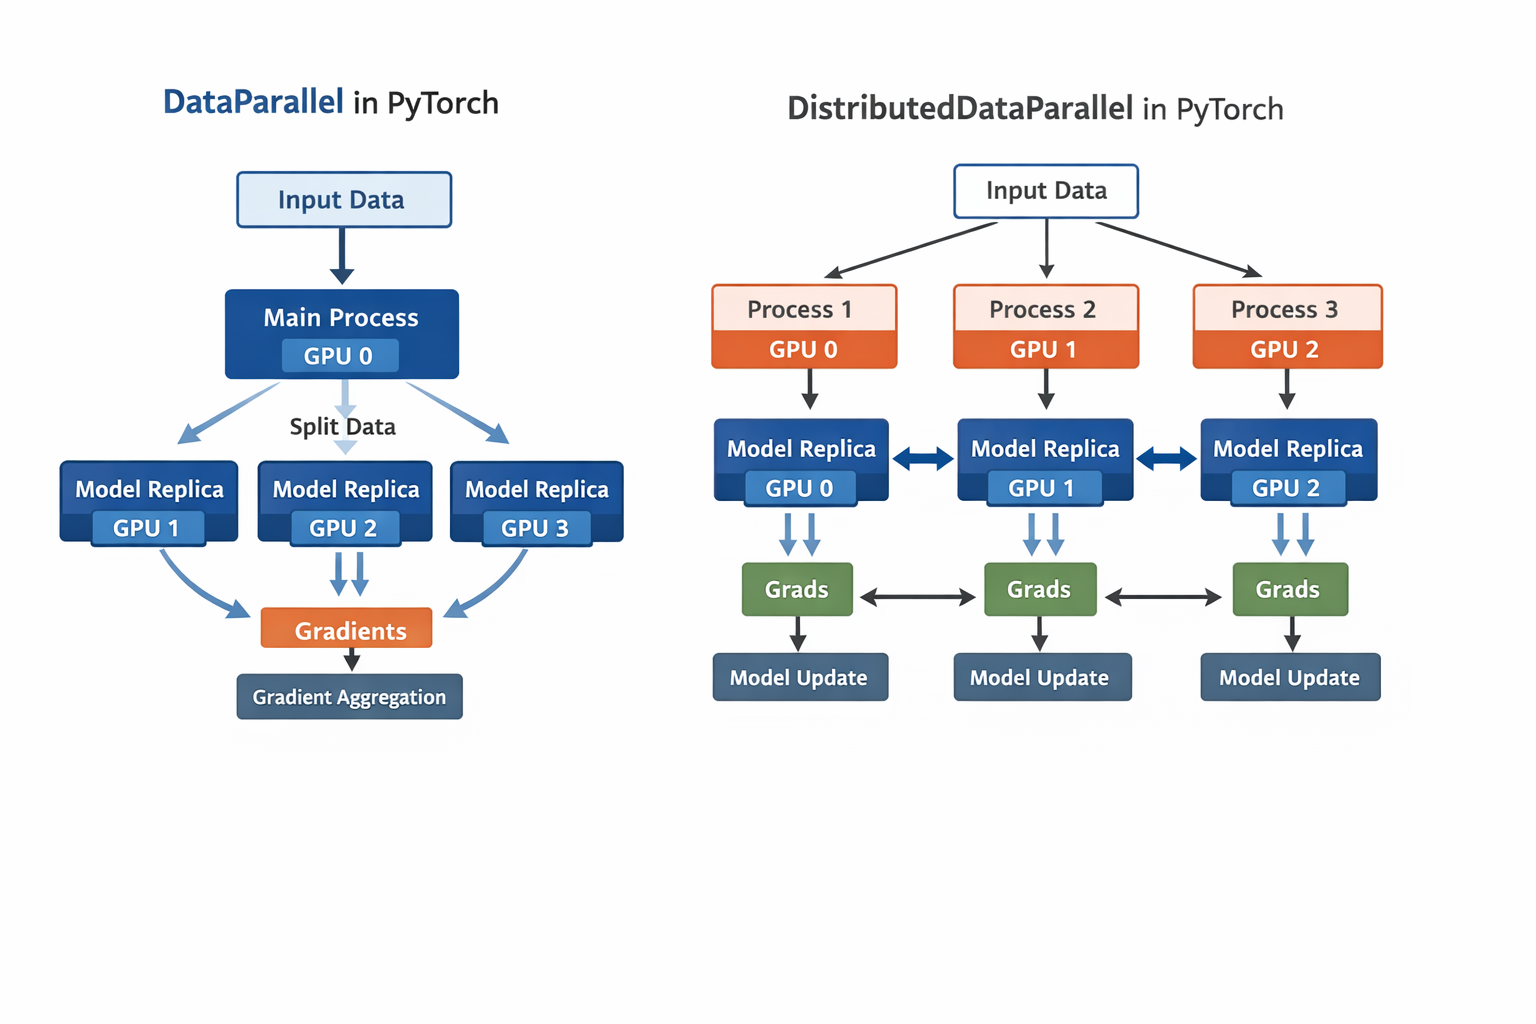

Key takeaways from the visual:

-   **`DataParallel` (left)**:
    -   Uses a single main process on a primary GPU (GPU 0).
    -   This main process splits the data and sends it to the other GPUs.
    -   Gradients are gathered back on the primary GPU for aggregation, creating a potential bottleneck.

-   **`DistributedDataParallel` (right)**:
    -   Creates an independent process for each GPU.
    -   Each process handles its own data and model replica.
    -   Gradients are synchronized across all processes in a decentralized manner (all-reduce), which is much more efficient.